In [1]:
#@title
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and di

In [1]:
#@title
import requests, json
from tqdm import tqdm
from bs4 import BeautifulSoup
import urllib.parse as parse
import pandas as pd
#visualization
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import sklearn as sk
import seaborn as sns

# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')

# font_list = [font.name for font in fm.fontManager.ttflist]
# font_list

In [8]:
#@title
df = pd.read_csv("1번토픽_모든장르(최종).csv")

> # 웹툰 평점은 믿을 게 못 돼. 새로운 점수를 만들어보자.
>> ### 댓글 반응이 진짜 반응 아닌가? 회차별 평점에 베스트 댓글의 공감 비율을 곱해보면 어떨까?
>> ### 베스트 댓글의 공감 비율은 일단 댓글점수라고 명명하자.
>> ### 평점은 0-10 사이에 있고 댓글점수는 0-100 사이에 있다. 곱한 다음 100을 나눠 나오는 값은 다시 0-10 사이에 있게 된다. 이걸 새점수라고 해보자!
>> ### 평점/댓글점수가 모두 높거나 낮을 때는 새점수 역시 높거나 낮아진다.
>> ### 평점이 낮을 때 댓글 점수가 높다면 새점수는 높아진다.
>>> #### 평점이 낮을 때 달리는 댓글은 부정적인 경향
>>> #### 그 댓글에 공감이 많다는 것은?
>>> #### "작품은 망했지만 댓글이 맛집인 것도 웹툰을 보는 재미지!"
>> ### 평점이 높을 때 댓글 점수가 낮다면 새점수는 낮아진다.
>>> #### 평점이 높을 때 달리는 댓글은 긍정적인 경향
>>> #### 그 댓글에 비공감이 많다는 것은?
>>> #### "평점 높은 것도 이해가 안 가고 댓글 왜이래!"

> ### '댓글점수' 컬럼 추가

In [9]:
#@title
df['댓글점수'] = ((df['베댓공감수']/(df['베댓공감수']+df['베댓비공감수']))*10).round(2)

> ### '새점수' 컬럼 추가  --> 평점에 댓글점수 가중치를 더한 값

In [10]:
#@title
df['새점수'] = ((df['평점']*df['댓글점수'])/10).round(2)

> ### '평점'과 '새점수'의 표준편차 비교 --> 네이버웹툰 평점의 신뢰도가 떨어짐을 보여주는 지표

In [11]:
#@title
df['평점'].std()

0.6022797325807544

In [12]:
#@title
df['새점수'].std()

1.4597044717682475

In [13]:
#@title
df['평점표준화'] = (((df['평점'] - df.mean()['평점'])/df.std()['평점'])).round(2)
df['새점수표준화'] = (((df['새점수'] - df.mean()['새점수'])/df.std()['새점수'])).round(2)

> ### 같은 평점, 다른 댓글점수
> #### '와탕카' 와 '로어올림푸스'

In [14]:
#@title
# df = df[['장르', '제목', '평점', '댓글점수', '새점수']]
rate_990 = df[df['평점'] == 9.90].groupby('제목').mean().round(2)

In [15]:
#@title
rate_990['새점수'].describe()  #new_score의 최솟값, 최댓값 확인

count    66.000000
mean      9.609697
std       0.405383
min       6.590000
25%       9.560000
50%       9.700000
75%       9.757500
max       9.870000
Name: 새점수, dtype: float64

In [16]:
#@title
rate_990_min = rate_990[rate_990['새점수'] == 6.59]  #평점:9.90, new_score: 최저
rate_990_max = rate_990[rate_990['새점수'] == 9.87]  #평점:9.90, new_score: 최대
pd.concat([rate_990_min, rate_990_max])

,회차,좋아요수,평점,평점기여자수,전체댓글수,베댓공감수,베댓비공감수,댓글점수,새점수,평점표준화,새점수표준화
제목,,,,,,,,,,,
와탕카,243.88,16.88,9.9,214.5,321.5,19.12,12.0,6.66,6.59,0.24,-1.81
로어올림푸스,24.00,4198.00,9.9,4622.0,1002.0,98758.00,293.0,9.97,9.87,0.24,0.43


> ### 다른평점, 다른 댓글점수
>> #### 'MLB카툰' 과 '골방환상곡'

In [17]:
#@title
comment_900 = df[df['댓글점수'] == 9.00].groupby('제목').mean().round(2)

In [18]:
#@title
comment_900['평점'].describe()  #new_score의 최솟값, 최댓값 확인

count    7.000000
mean     9.484286
std      0.814900
min      7.660000
25%      9.640000
50%      9.740000
75%      9.890000
max      9.930000
Name: 평점, dtype: float64

In [19]:
#@title
comment_900_min = comment_900[comment_900['평점'] == 7.66]  #new_score: 9.90, 평점: 최소
comment_900_max = comment_900[comment_900['평점'] == 9.93]  #new_score: 9.90, 평점: 최대
pd.concat([comment_900_min, comment_900_max])

,회차,좋아요수,평점,평점기여자수,전체댓글수,베댓공감수,베댓비공감수,댓글점수,새점수,평점표준화,새점수표준화
제목,,,,,,,,,,,
MLB카툰,596.0,2.0,7.66,273.5,57.5,27.0,3.0,9.0,6.90,-3.47,-1.60
골방환상곡,236.0,378.0,9.93,1208.0,1836.0,315.0,35.0,9.0,8.94,0.29,-0.21


> ### 웹툰 3개 평점과 새점수 비교

In [20]:
#@title
cond = (df['평점'] >= 9.5) & (df['새점수'] <= 8)
df[cond]['제목'].unique()

array(['와탕카', '자율공상축구탐구만화', '윌유메리미'], dtype=object)

In [21]:
#@title
rcParams['figure.figsize'] = 16, 8 # 플랏 크기 조절
rcParams['font.size'] = '18' # 폰트 크기 조절

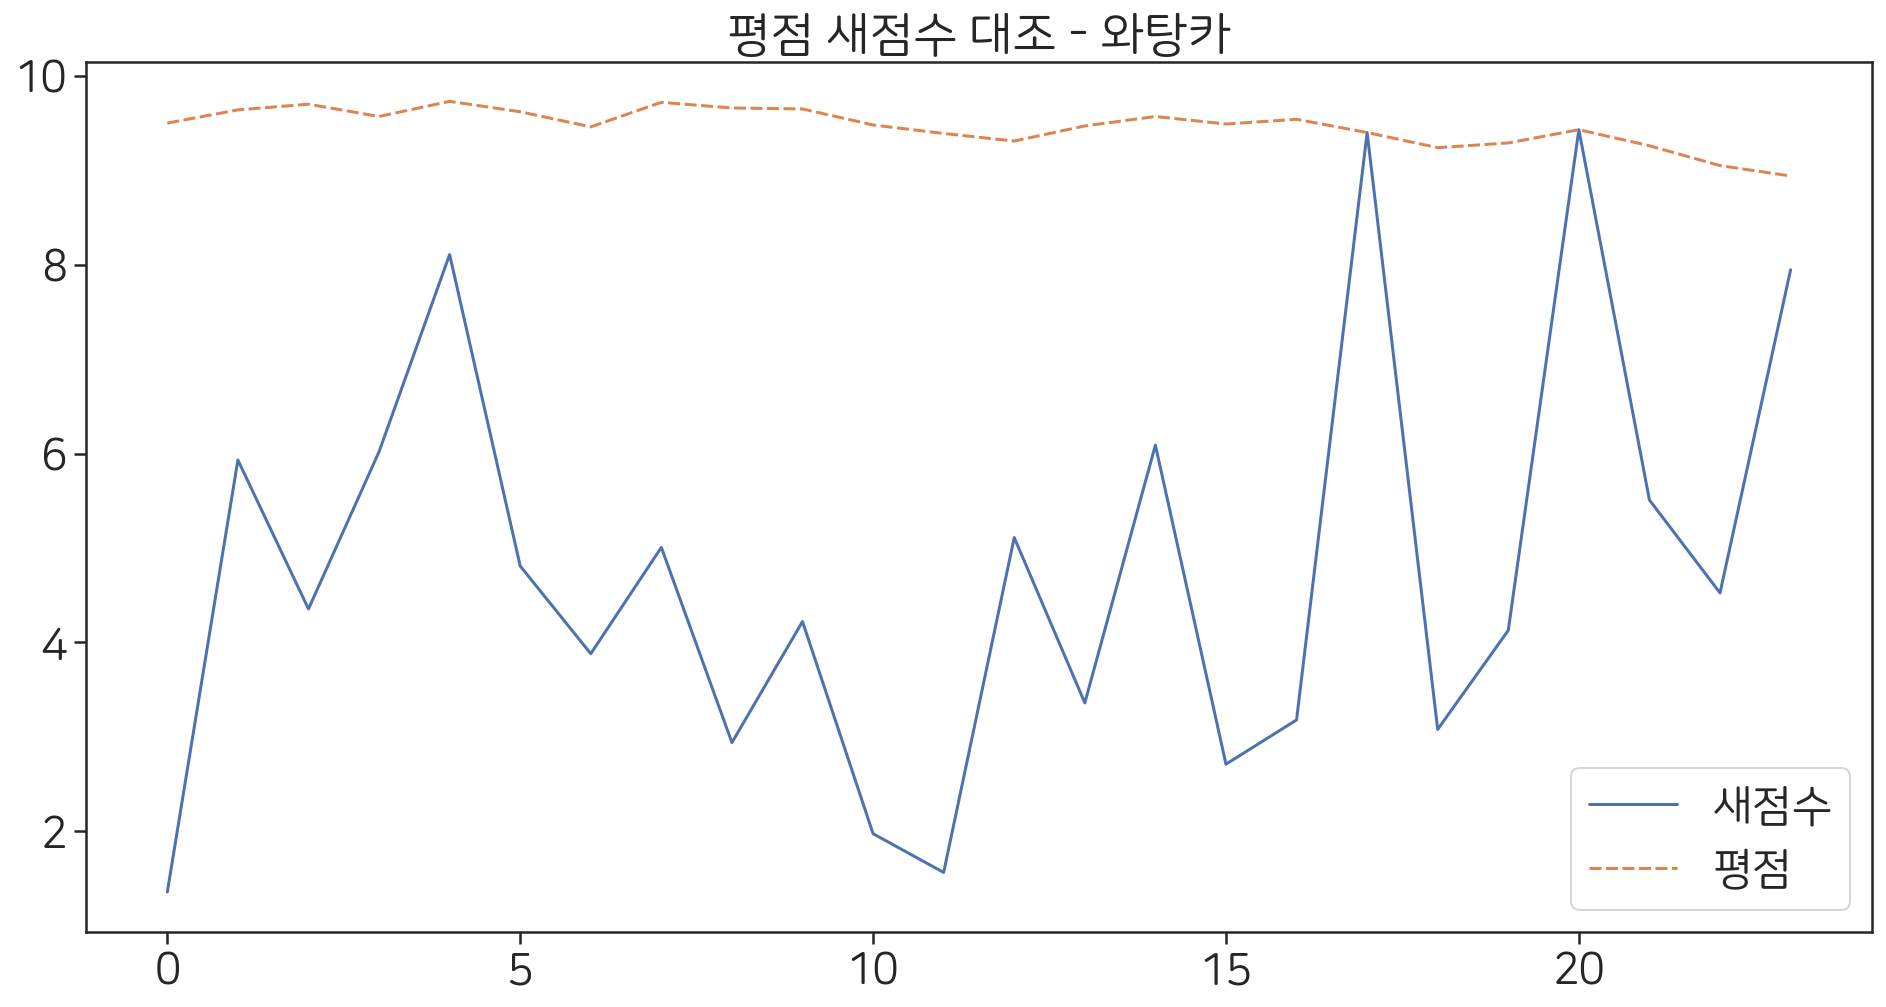

In [22]:
#@title
df_1 = df[df['제목'] == '와탕카'][-24:]
symPerTotalPathy = (df_1['베댓공감수']/(df_1['베댓공감수']+df_1['베댓비공감수']))*100
newScore = df_1['평점'] * symPerTotalPathy / 100
starScore = df_1['평점']
temp = {
    '새점수': newScore,
    '평점': starScore,
    # '공/공+비 비율': symPerTotalPathy,
}
plot = pd.DataFrame(temp).reset_index().drop('index', axis=1)
plt.title('평점 새점수 대조 - 와탕카')

sns.lineplot(data=plot)
print()

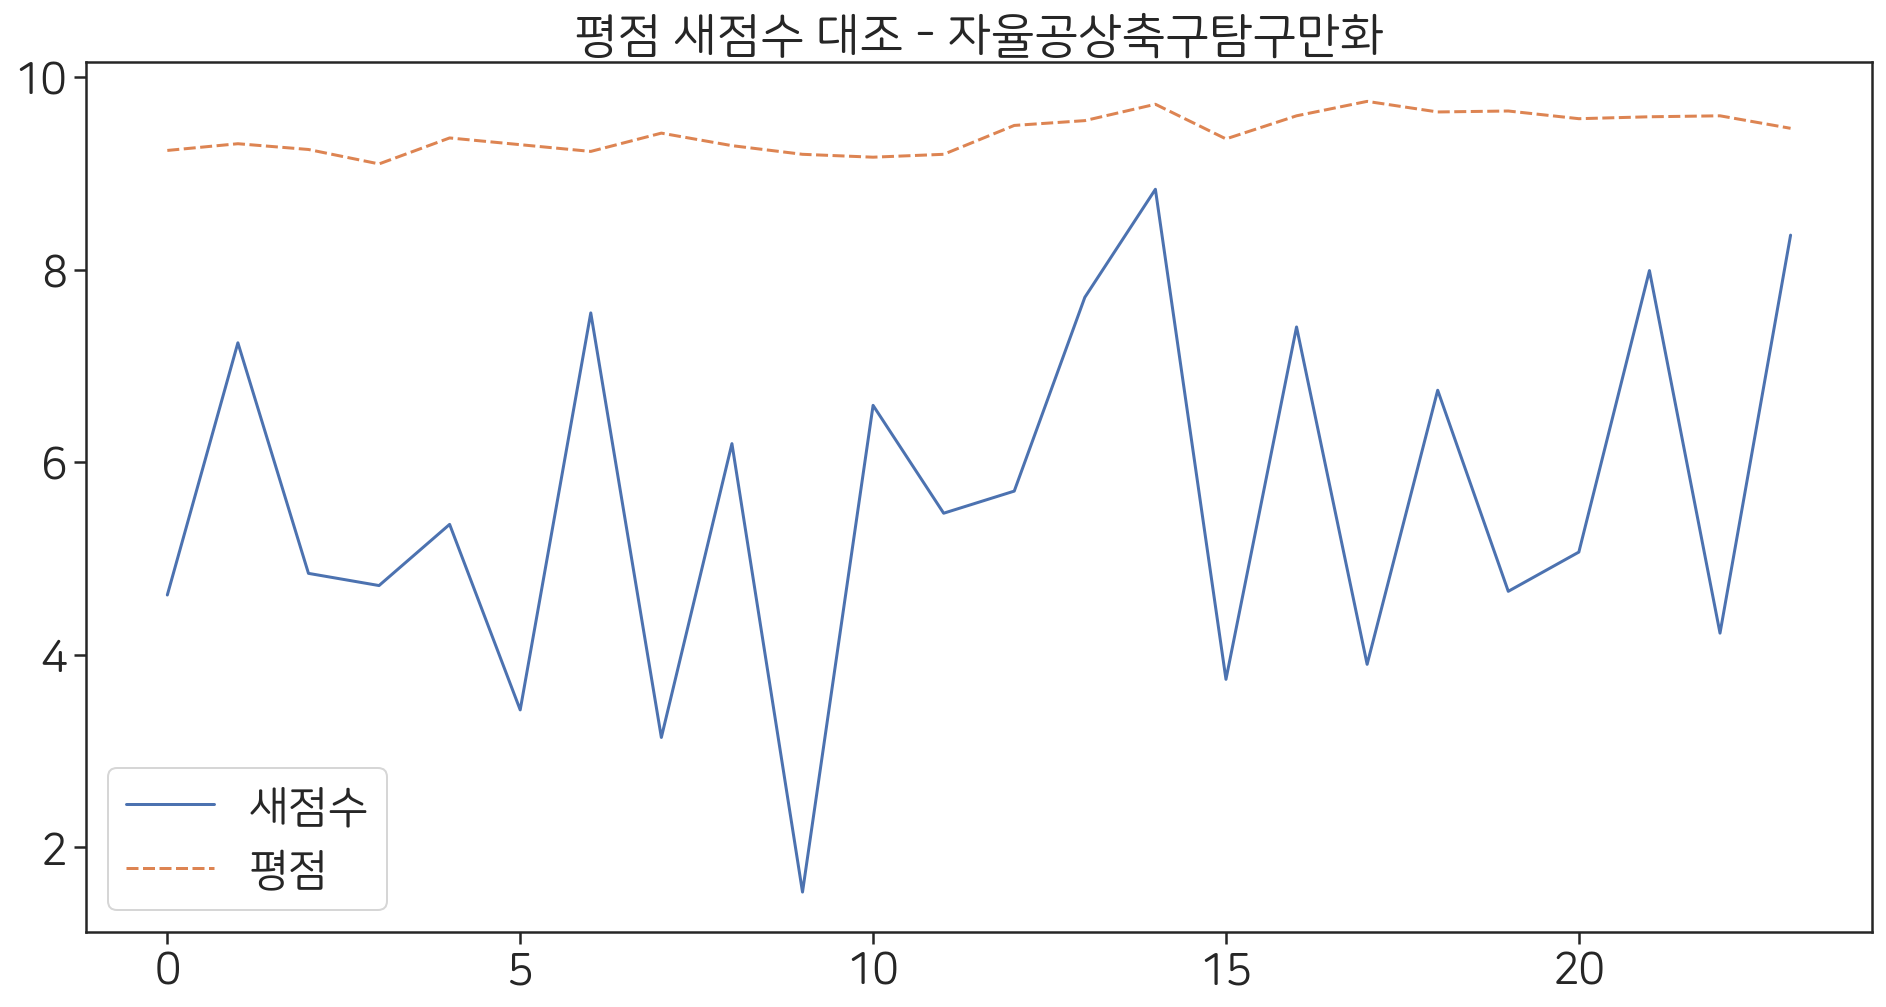

In [23]:
#@title
df_2 = df[df['제목'] == '자율공상축구탐구만화'][-24:]

symPerTotalPathy = (df_2['베댓공감수']/(df_2['베댓공감수']+df_2['베댓비공감수']))*100
newScore = df_2['평점'] * symPerTotalPathy / 100
starScore = df_2['평점']
temp = {
    '새점수': newScore,
    '평점': starScore,
    # '공/공+비 비율': symPerTotalPathy,
}
plot = pd.DataFrame(temp).reset_index().drop('index', axis=1)
plt.title('평점 새점수 대조 - 자율공상축구탐구만화')

sns.lineplot(data=plot)
print()

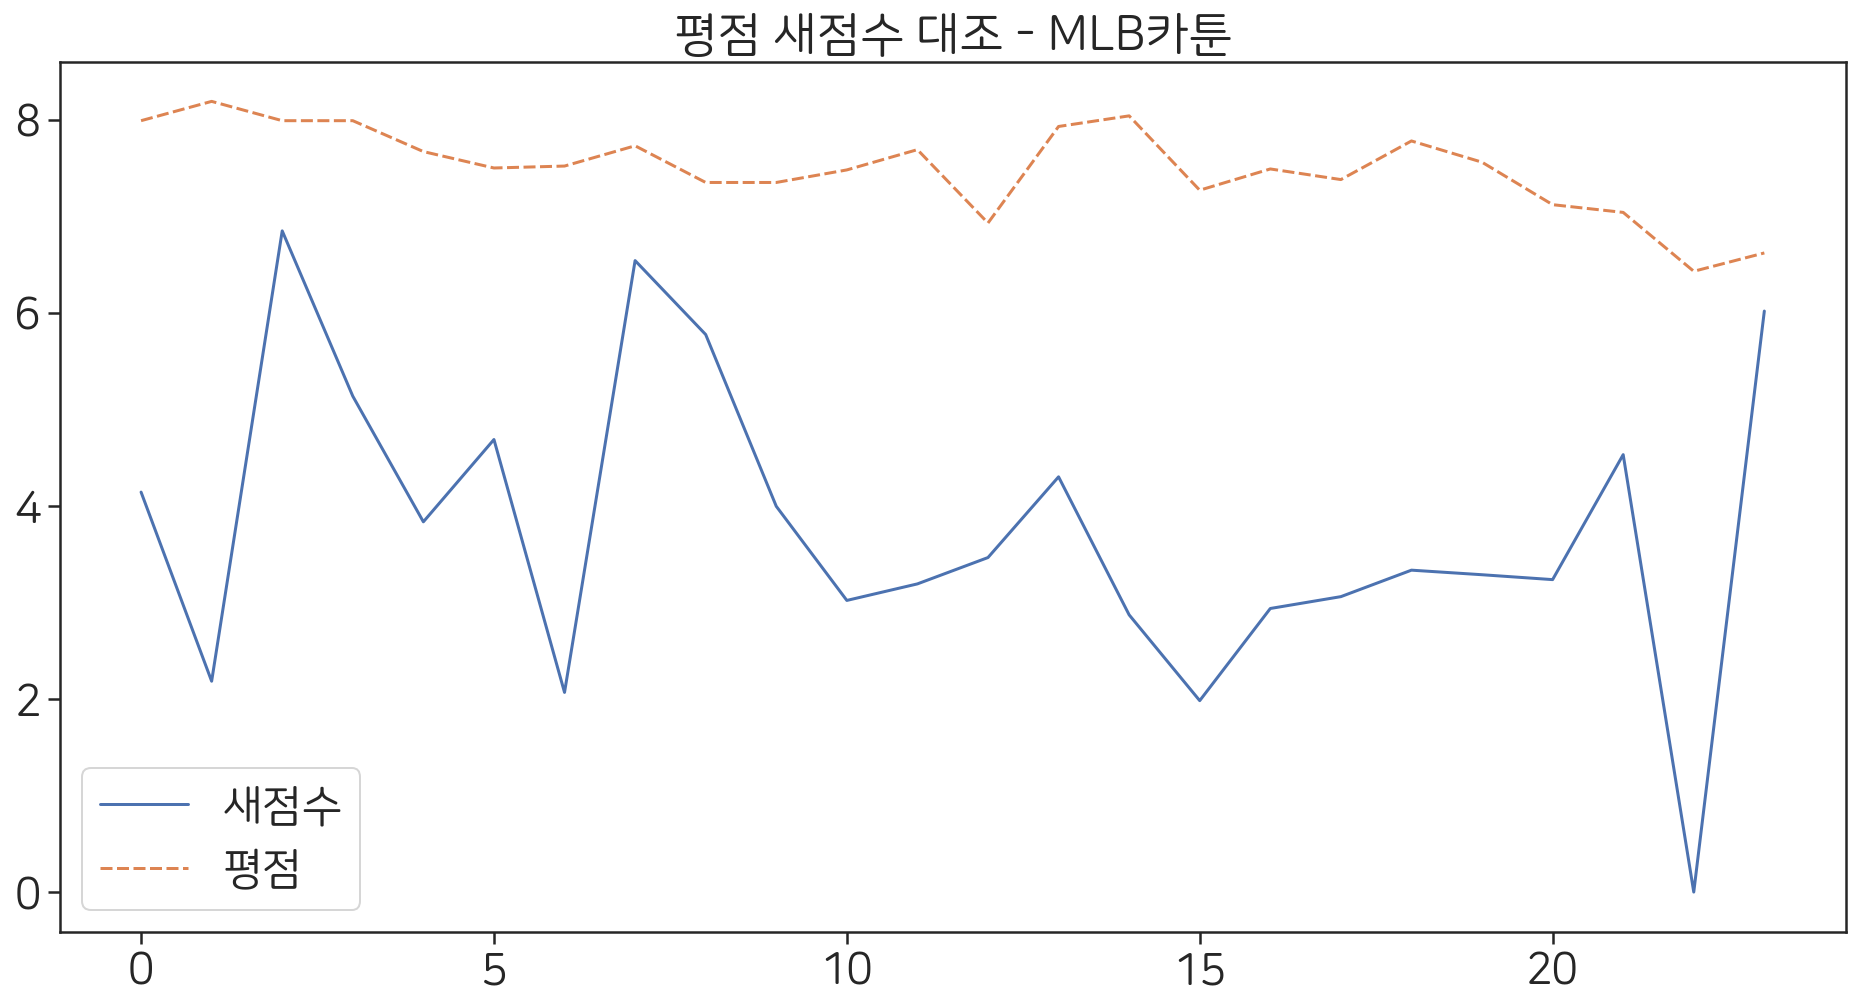

In [24]:
#@title
df_3 = df[df['제목'] == 'MLB카툰'][-24:]

symPerTotalPathy = (df_3['베댓공감수']/(df_3['베댓공감수']+df_3['베댓비공감수']))*100
newScore = df_3['평점'] * symPerTotalPathy / 100
starScore = df_3['평점']
temp = {
    '새점수': newScore,
    '평점': starScore,
    # '공/공+비 비율': symPerTotalPathy,
}
plot = pd.DataFrame(temp).reset_index().drop('index', axis=1)
plt.title('평점 새점수 대조 - MLB카툰')

sns.lineplot(data=plot)
print()

> ### 평점과 새점수의 편차 비교

<Figure size 288x360 with 0 Axes>

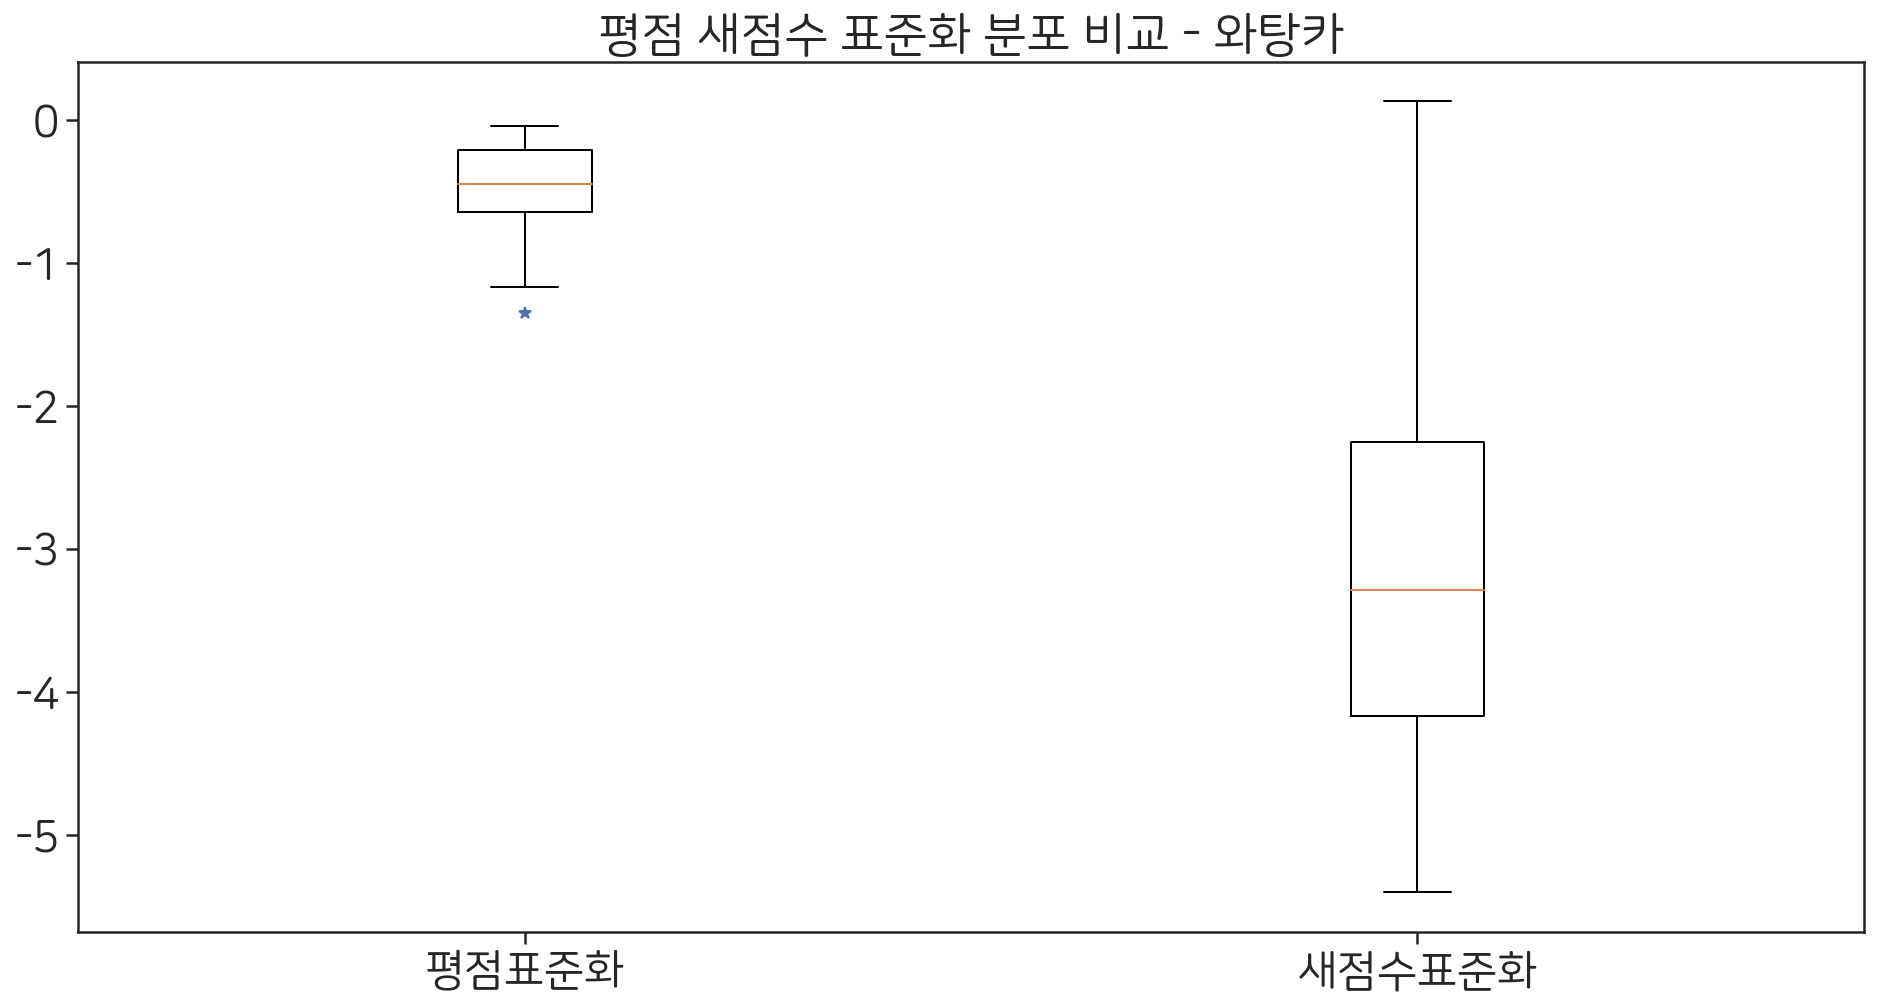

In [25]:
#@title
df_1 = df[df['제목'] == '와탕카'][-24:]
df_1
rcParams['font.size'] = '15'
plt.figure(figsize = (4, 5))
fig, ax = plt.subplots()

ax.boxplot([df_1['평점표준화'], df_1['새점수표준화']], sym="b*")

plt.title('평점 새점수 표준화 분포 비교 - 와탕카')
plt.xticks([1, 2], ['평점표준화', '새점수표준화'])

plt.show()


<Figure size 288x360 with 0 Axes>

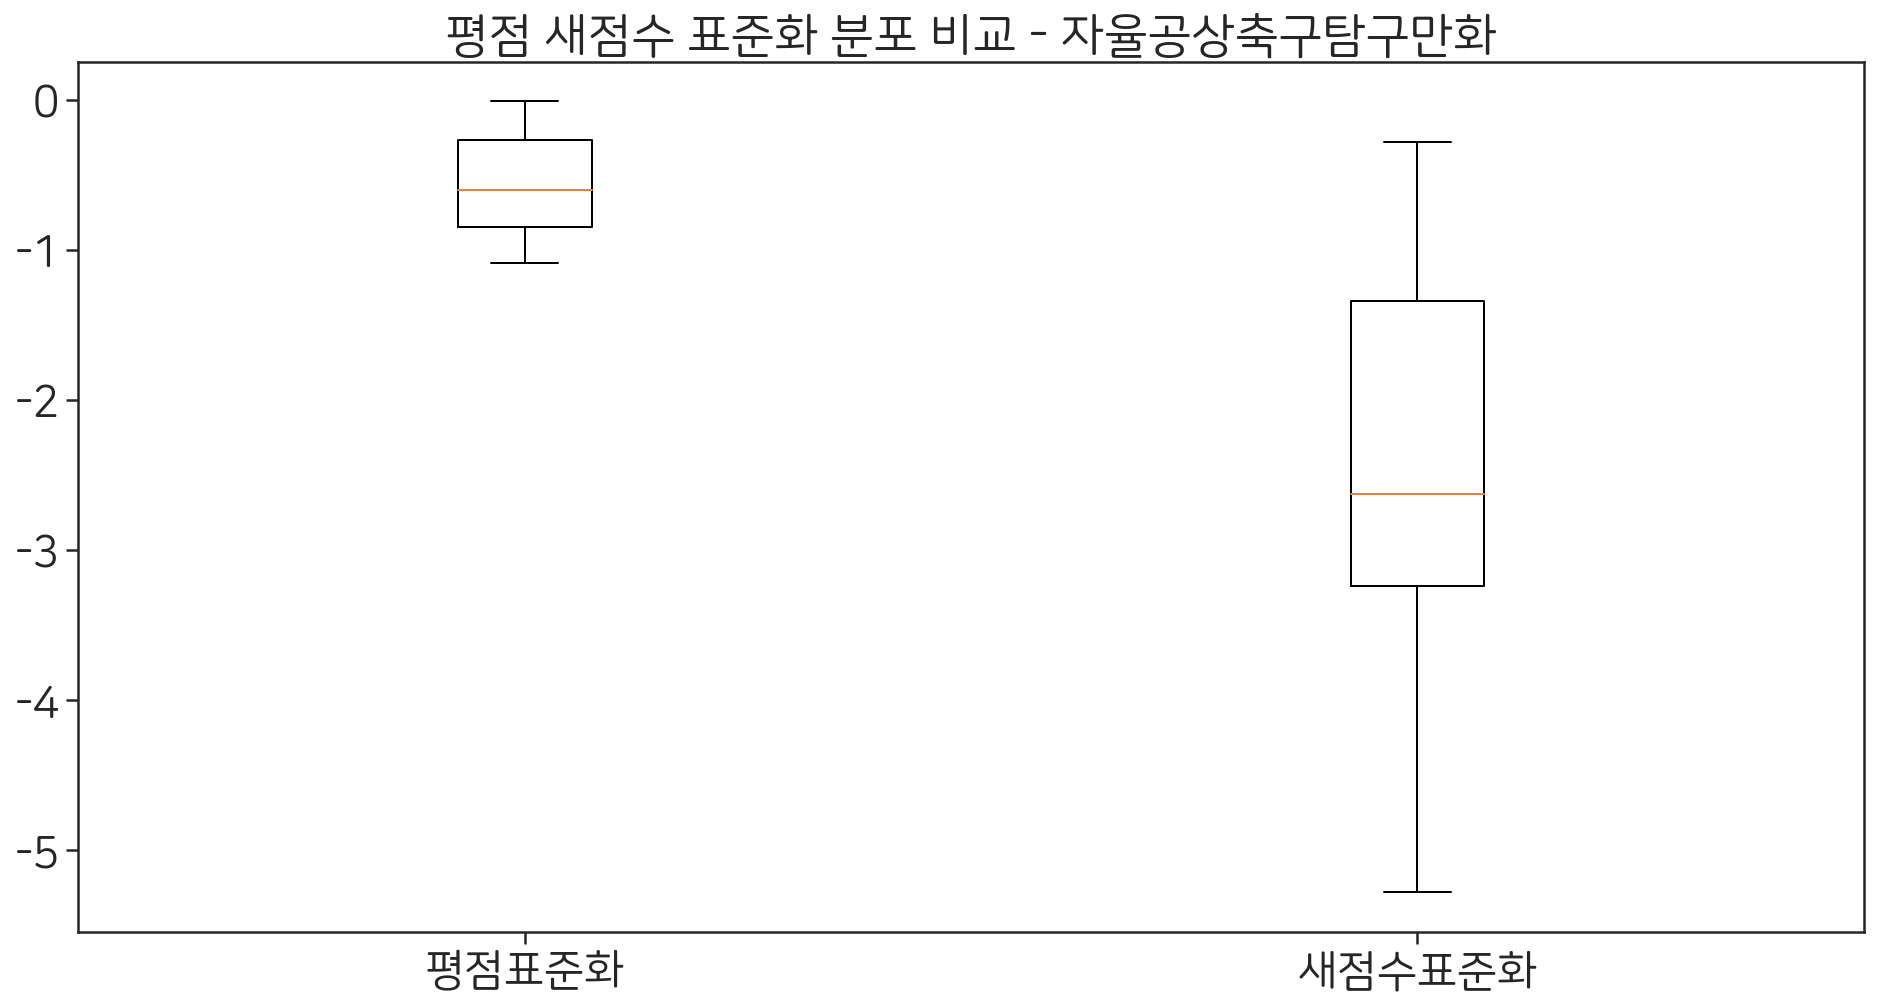

In [26]:
#@title
df_2 = df[df['제목'] == '자율공상축구탐구만화'][-24:]

rcParams['font.size'] = '15'
plt.figure(figsize = (4, 5))
fig, ax = plt.subplots()

ax.boxplot([df_2['평점표준화'], df_2['새점수표준화']], sym="b*")

plt.title('평점 새점수 표준화 분포 비교 - 자율공상축구탐구만화')
plt.xticks([1, 2], ['평점표준화', '새점수표준화'])

plt.show()



<Figure size 288x360 with 0 Axes>

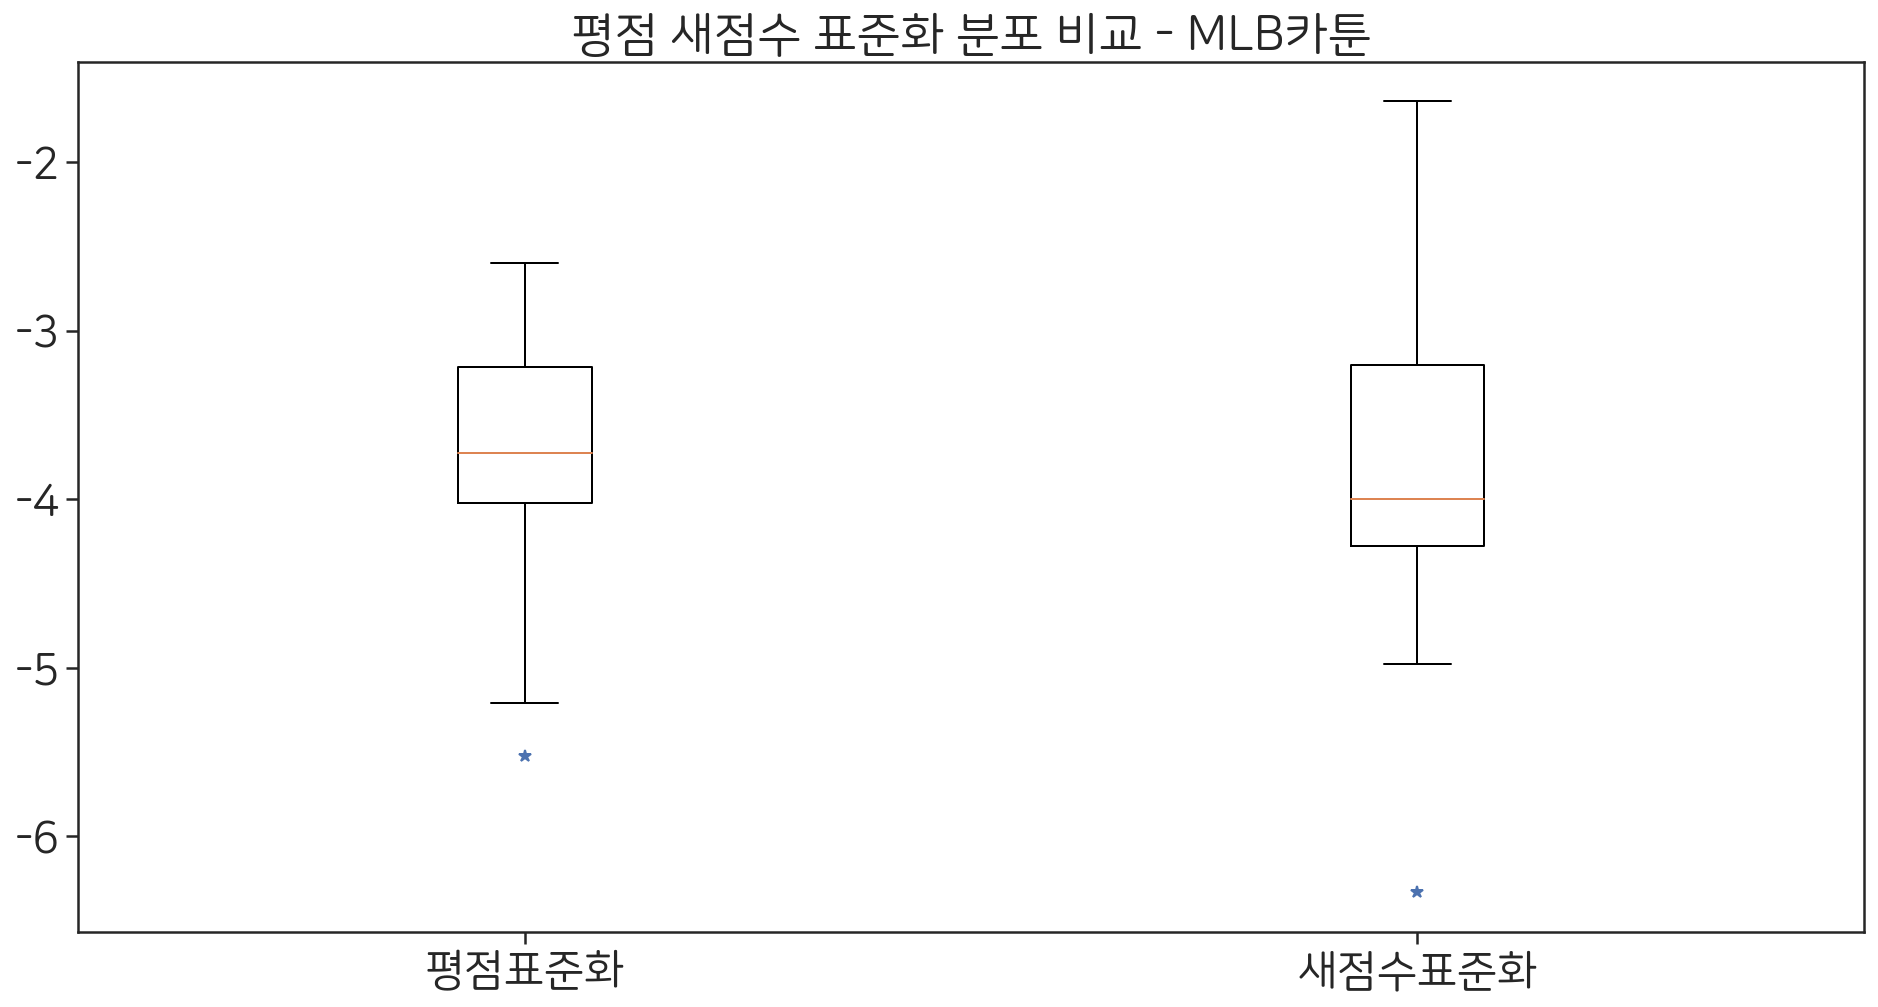

In [27]:
#@title
df_3 = df[df['제목'] == 'MLB카툰'][-24:]

rcParams['font.size'] = '15'
plt.figure(figsize = (4, 5))
fig, ax = plt.subplots()

ax.boxplot([df_3['평점표준화'], df_3['새점수표준화']], sym="b*")

plt.title('평점 새점수 표준화 분포 비교 - MLB카툰')
plt.xticks([1, 2], ['평점표준화', '새점수표준화'])

plt.show()